<center><h1>Incorporate n-grams with word embeddings</h1></center>

How can we incorporate N-Grams features with our word embedding, we use **convolution**.

<center><img src="https://cezannec.github.io/assets/cnn_text/conv_maxpooling_steps.gif"></center>

The window size indicate the N in N-gram, like for example if the kernel size is `3x300`, this means 3-grams model and so on 

In [1]:
import spacy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

nlp = spacy.load("en_core_web_md")
dataset = pd.read_csv("../../data/chatbot-data.tsv", sep="\t")

In [2]:
dataset.head()

,Unnamed: 0,text,intent
0,0,hello there,greetings
1,1,good morning,greetings
2,2,welcome,greetings
3,3,"hi!, how are you",greetings
4,4,Hi there !!,greetings


In [3]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input

In [4]:
longest_input = get_longest_text(dataset['text'])
longest_input

11

In [5]:
data_emb = np.zeros((len(dataset), longest_input, 300))
for i, text in enumerate(tqdm(nlp.pipe(dataset['text']), total=len(dataset))):
    for j, token in enumerate(text):
        data_emb[i, j] = token.vector

  0%|          | 0/35 [00:00<?, ?it/s]

In [6]:
# prepare y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(dataset['intent'])
y_encoded = to_categorical(y_encoded)

In [7]:
y_encoded[:10]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [8]:
import tensorflow as tf

# define the network
inputs = tf.keras.layers.Input((longest_input, 300))
reshaped = tf.keras.layers.Reshape((longest_input, 300, 1))(inputs)


filters = [2, 3, 4]

# define the conv net
conv_1 = tf.keras.layers.Conv2D(100, (filters[0], 300), activation='relu')(reshaped)
conv_2 = tf.keras.layers.Conv2D(100, (filters[1], 300), activation='relu')(reshaped)
conv_3 = tf.keras.layers.Conv2D(100, (filters[2], 300), activation='relu')(reshaped)

# define max-pooling
pool_1 = tf.keras.layers.MaxPooling2D((longest_input - filters[0] + 1, 1), strides=(1,1))(conv_1)
pool_2 = tf.keras.layers.MaxPooling2D((longest_input - filters[1] + 1, 1), strides=(1,1))(conv_2)
pool_3 = tf.keras.layers.MaxPooling2D((longest_input - filters[2] + 1, 1), strides=(1,1))(conv_3)

# concatenate the convs
merged_tensor = tf.keras.layers.concatenate([pool_1, pool_2, pool_3], axis=1)

# now flatten them and add a dense layer
flatten = tf.keras.layers.Flatten()(merged_tensor)

# add a dense layer
clf = tf.keras.layers.Dense(100, activation='relu')(flatten)

# add final output
clf = tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')(clf)

In [9]:
# compile the model
model = tf.keras.models.Model(inputs, clf)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11, 300)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 11, 300, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 10, 1, 100)   60100       ['reshape[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 9, 1, 100)    90100       ['reshape[0][0]']                
                                                                                              

In [10]:
!pip install pydot graphviz

/home/ali/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ali/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


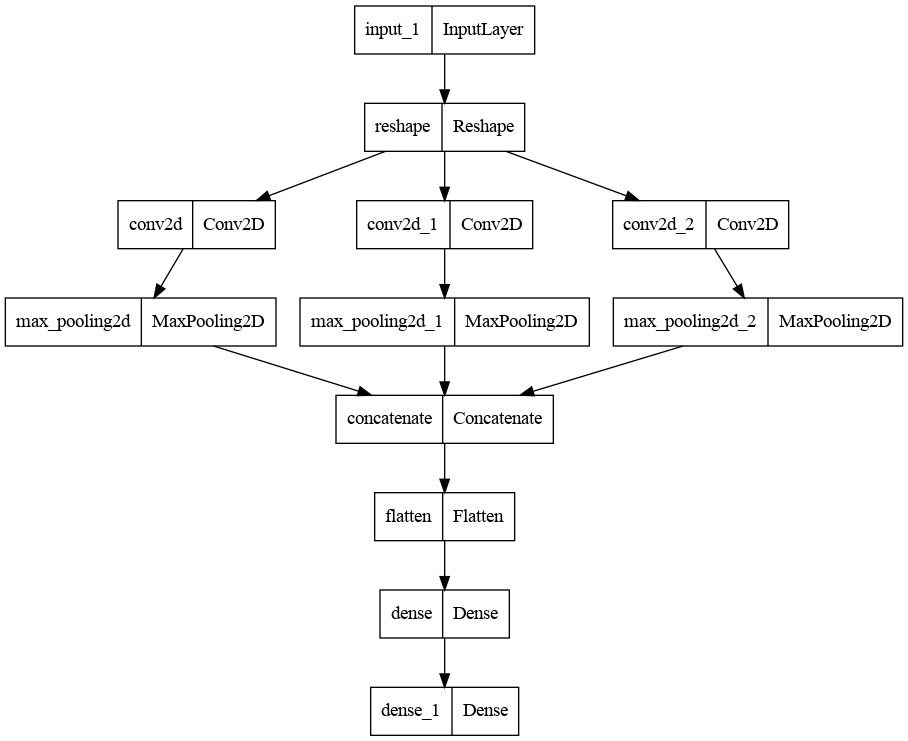

In [11]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [12]:
# let's split the data and train our model
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_emb, y_encoded, test_size=.2)

In [13]:
# train our model
model.fit(x_train, y_train, epochs=23)

Epoch 1/23
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 2s 2s/step - loss: 1.9641 - acc: 0.1071
Epoch 2/23
1/1 [==============================] - 0s 9ms/step - loss: 1.7346 - acc: 0.5714
Epoch 3/23
1/1 [==============================] - 0s 10ms/step - loss: 1.4875 - acc: 0.7500
Epoch 4/23
1/1 [==============================] - 0s 13ms/step - loss: 1.2376 - acc: 0.8929
Epoch 5/23
1/

In [14]:
model.evaluate(x_test, y_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 215ms/step - loss: 2.1483 - acc: 0.4286


[2.148284673690796, 0.4285714328289032]

Let's make a prediction function

In [15]:
encoder.classes_[4]

'reserve_enq'

In [16]:
text = "Hello do you have python courses?"
text_v = np.zeros((1, longest_input, 300))
for i, token in enumerate(nlp(text)):
    if i>=longest_input:
        break
    text_v[0, i] = token.vector
predictions = model.predict(text_v)
predictions

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[7.5312388e-01, 1.4047691e-01, 2.5648747e-03, 4.3487608e-02,
        4.6262581e-02, 4.6202188e-04, 1.3622116e-02]], dtype=float32)

In [17]:
np.argmax(predictions)

0

In [18]:
for label, prob in zip(encoder.classes_, predictions[0]):
    print((label, round(prob, 3)))

('availability_enq', 0.753)
('cost_enq', 0.14)
('duration_enq', 0.003)
('greetings', 0.043)
('reserve_enq', 0.046)
('start_enq', 0.0)
('thanks', 0.014)


In [19]:
def predict_n_gram(text):
    text_v = np.zeros((1, longest_input, 300))
    for i, token in enumerate(nlp(text)):
        if i>=longest_input:
            break
        text_v[0, i] = token.vector
    # predict the input 
    prediction = model.predict(text_v)
    label = encoder.classes_[np.argmax(prediction)]
    return label

In [20]:
predict_n_gram("how much for the french course?")

'cost_enq'